In [1]:
import os 
import cv2
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리
print(cv2.__version__)
print(dlib.__version__)

4.12.0
20.0.0


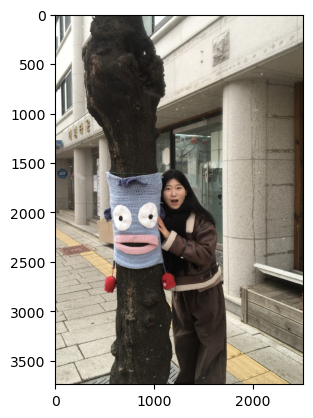

In [3]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/AIFFEL_quest_rs/Exploration/EX01/images/taekyung.jpg') # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

In [4]:
# detector 불러오기
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(1083, 1703) (1306, 1926)]]


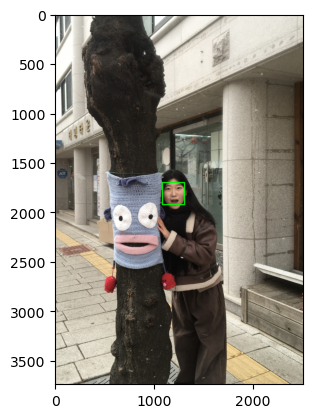

In [5]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 9, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 영역이 너무 멀리있으니 얼굴을 기준으로 이미지를 조금 crop해보겠습니다

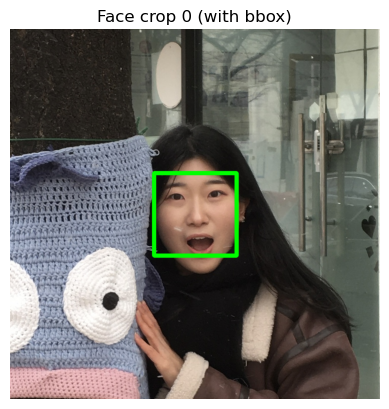

In [6]:
# crop은 dlib를 통해 찾은 얼굴을 기준으로 (1000,1000) 으로 crop하겠습니다.
h, w, _ = img_bgr.shape
crop_size = 1000
half = crop_size // 2

for idx, dlib_rect in enumerate(dlib_rects):
    
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    # 얼굴 bbox 중심
    cx = (l + r) // 2
    cy = (t + b) // 2

    # crop 좌표 계산
    x1 = cx - half
    y1 = cy - half
    x2 = cx + half
    y2 = cy + half

    # 이미지 경계 보정 (crop영역이 이미지 경계를 넘지 않도록)
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w, x2)
    y2 = min(h, y2)

    # 🔹 원본 이미지 crop
    face_crop_raw = img_bgr[y1:y2, x1:x2]

    # 🔹 출력용 이미지 crop (bbox 포함)
    face_crop_show = img_show[y1:y2, x1:x2]

    #crop 기준 bbox 생성
    crop_rect = dlib.rectangle(
    left   = l - x1,
    top    = t - y1,
    right  = r - x1,
    bottom = b - y1
    )   

    # 🔹 시각화 (출력용 crop)
    face_crop_rgb = cv2.cvtColor(face_crop_show, cv2.COLOR_BGR2RGB)
    plt.imshow(face_crop_rgb)
    plt.title(f"Face crop {idx} (with bbox)")
    plt.axis("off")
    plt.show()


In [7]:
# plt.imshow(face_crop_raw)
# plt.imshow(face_crop_show)

In [10]:
# pre-trained 모델 불러오기 ~
model_path = os.path.join(home_dir, 'work/AIFFEL_quest_rs/Exploration/EX01/models/shape_predictor_68_face_landmarks.dat')
landmark_predictor = dlib.shape_predictor(model_path)

In [11]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(face_crop_show, crop_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


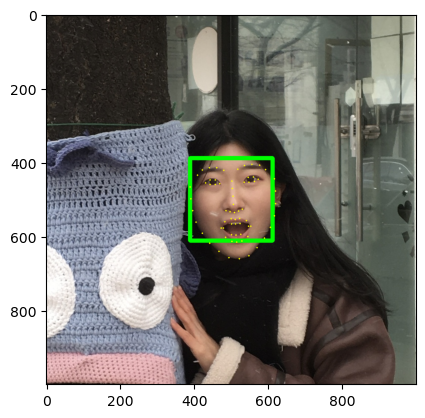

In [12]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(face_crop_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(face_crop_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

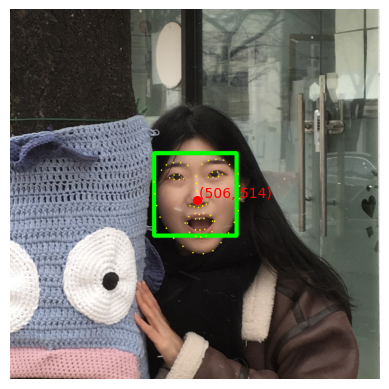

In [13]:
# 내가 찍고 싶은 Point 시각화해보기
nose = list_landmarks[0][30]

# 찍고 싶은 좌표
x_1, y_1 = nose[0], nose[1]

plt.imshow(img_show_rgb)
plt.scatter(x_1, y_1, c='red', s=30)  # 점 찍기
plt.text(x_1+5, y_1-5, f"({x_1}, {y_1})", color='red', fontsize=10)
plt.axis("off")
plt.show()


In [14]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (nose) # 30번 index가 코 끝을 보여줌
    x = nose[0] # 이미지에서 코 부위의 x값
    y = nose[1] # 우리는 코 위에다가 사진을 붙일거니까 !! 
    
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(506, 514)
(x,y) : (506,514)
(w,h) : (224,224)


스티커 이미지 불러오기

(224, 224, 4)


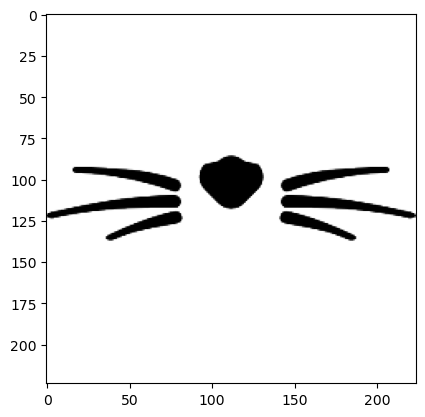

In [15]:
sticker_path = os.path.join(home_dir, 'work/AIFFEL_quest_rs/Exploration/EX01/images/cat-whiskers.png') # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인
plt.imshow(img_sticker)

In [16]:
# (x,y) 기준점을 기반으로 스티커의 좌측 상단 좌표 계산
refined_x = x - w // 2 
refined_y = y - h //2
print (f'(x,y) : ({refined_x},{refined_y})')

# 스티커가 이미지의 왼쪽 경계를 벗어난 경우
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

# 스티커가 이미지의 위쪽 경계를 벗어난 경우
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
    
# 최종적으로 보정된 스티커 좌측 상단 좌표
print (f'(x,y) : ({refined_x},{refined_y})')

# 우리는 영향 x

(x,y) : (394,402)
(x,y) : (394,402)


In [17]:
# face_crop_show에서 스티커를 붙일 영역을 잘라냄
# 스티커 크기(H, W)에 맞는 원본 배경 영역

sticker_area = face_crop_show[
    refined_y:refined_y+img_sticker.shape[0], 
    refined_x:refined_x+img_sticker.shape[1]
]

# 스티커 이미지에서 RGB 채널만 분리
sticker_rgb = img_sticker[:, :, :3]

# 스티커 이미지에서 알파(alpha) 채널 분리
# 알파 채널은 각 픽셀의 투명도 정보를 의미
alpha = img_sticker[:, :, 3]

# 알파 값이 0보다 큰 위치만 True인 마스크 생성
alpha_mask = alpha[:, :, None] > 0  # (H, W, 1)

# 알파 마스크를 기준으로 픽셀 단위 합성 (np.where 사용)
out = np.where(
    alpha_mask,
    sticker_rgb,
    sticker_area
).astype(np.uint8)


# 합성된 결과를 face_crop_show 이미지에 붙이기
face_crop_show[
    refined_y:refined_y+img_sticker.shape[0],
    refined_x:refined_x+img_sticker.shape[1]
] = out

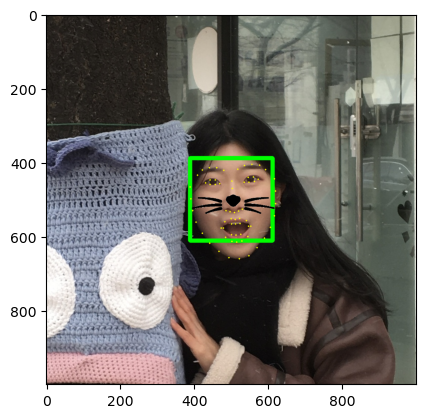

In [18]:
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(face_crop_show, cv2.COLOR_BGR2RGB))
plt.show()

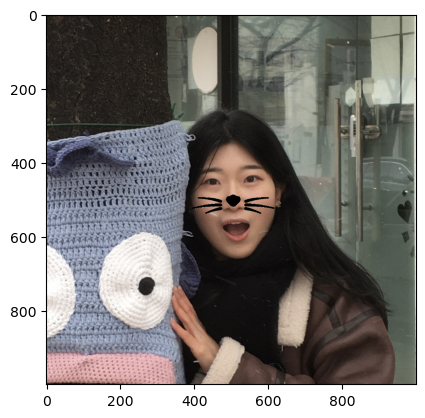

In [19]:
# 마찬가지로 raw image에 적용해주기
sticker_area_raw = face_crop_raw[
    refined_y:refined_y+img_sticker.shape[0],
    refined_x:refined_x+img_sticker.shape[1]
]

out_raw = np.where(
    alpha_mask,
    sticker_rgb,
    sticker_area_raw
).astype(np.uint8)

face_crop_raw[
    refined_y:refined_y+img_sticker.shape[0],
    refined_x:refined_x+img_sticker.shape[1]
] = out_raw

plt.imshow(cv2.cvtColor(face_crop_raw, cv2.COLOR_BGR2RGB))
plt.show()

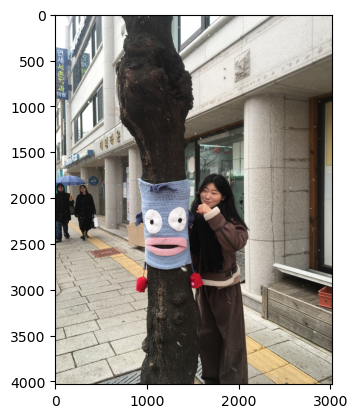

In [20]:
# 다른 각도에서의 이미지 적용해보기

# 다른 이미지 불러오기 (얼굴이 돌아가있는 경우)
my_path = os.path.join(home_dir, 'work/AIFFEL_quest_rs/Exploration/EX01/images/taekyung_2.jpg')
img_bgr = cv2.imread(my_path)
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

rectangles[[(273, 1887) (325, 1939)], [(1554, 1876) (1777, 2099)], [(31, 1870) (93, 1933)]]


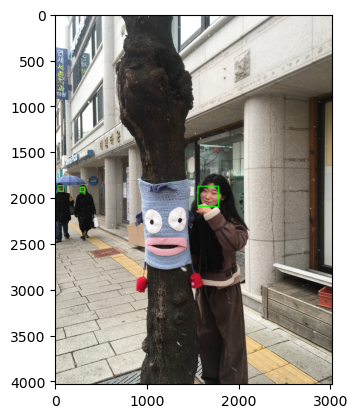

In [21]:
# 이미지 전처리(crop) 및 detector를 통한 얼굴 검출

dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 9, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


In [22]:
dlib_rects = dlib.rectangles([dlib_rects[1]])

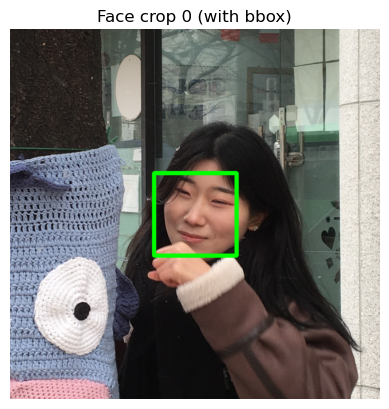

In [23]:
# crop은 dlib를 통해 찾은 얼굴을 기준으로 (1000,1000) 으로 crop하겠습니다.
h, w, _ = img_bgr.shape
crop_size = 1000
half = crop_size // 2

for idx, dlib_rect in enumerate(dlib_rects):
    
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    # 얼굴 bbox 중심
    cx = (l + r) // 2
    cy = (t + b) // 2

    # crop 좌표 계산
    x1 = cx - half
    y1 = cy - half
    x2 = cx + half
    y2 = cy + half

    # 이미지 경계 보정 (crop영역이 이미지 경계를 넘지 않도록)
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w, x2)
    y2 = min(h, y2)

    # 🔹 원본 이미지 crop
    face_crop_raw = img_bgr[y1:y2, x1:x2]

    # 🔹 출력용 이미지 crop (bbox 포함)
    face_crop_show = img_show[y1:y2, x1:x2]

    #crop 기준 bbox 생성
    crop_rect = dlib.rectangle(
    left   = l - x1,
    top    = t - y1,
    right  = r - x1,
    bottom = b - y1
    )   

    # 🔹 시각화 (출력용 crop)
    face_crop_rgb = cv2.cvtColor(face_crop_show, cv2.COLOR_BGR2RGB)
    plt.imshow(face_crop_rgb)
    plt.title(f"Face crop {idx} (with bbox)")
    plt.axis("off")
    plt.show()


68


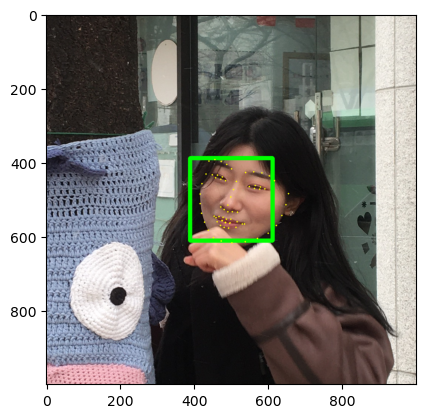

(491, 516)
(x,y) : (491,516)
(w,h) : (224,224)


In [24]:
# landmark 설정

list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(face_crop_show, crop_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))

# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(face_crop_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(face_crop_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

nose = list_landmarks[0][30]
for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (nose) # 30번 index가 코 끝을 보여줌
    x = nose[0] # 이미지에서 코 부위의 x값
    y = nose[1] # 우리는 코 위에다가 사진을 붙일거니까 !! 
    
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(x,y) : (379,404)
(x,y) : (379,404)


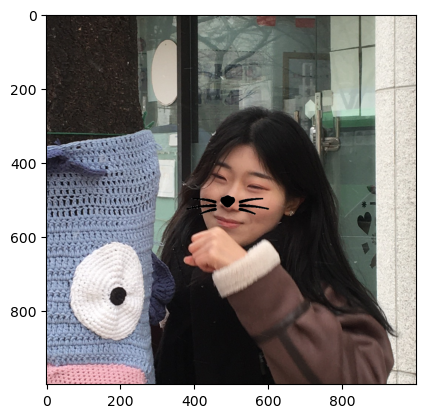

In [25]:
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
# (x,y) 기준점을 기반으로 스티커의 좌측 상단 좌표 계산
refined_x = x - w // 2 
refined_y = y - h //2
print (f'(x,y) : ({refined_x},{refined_y})')

# 스티커가 이미지의 왼쪽 경계를 벗어난 경우
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

# 스티커가 이미지의 위쪽 경계를 벗어난 경우
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
    
# 최종적으로 보정된 스티커 좌측 상단 좌표
print (f'(x,y) : ({refined_x},{refined_y})')

# 우리는 영향 x

# face_crop_show에서 스티커를 붙일 영역을 잘라냄
# 스티커 크기(H, W)에 맞는 원본 배경 영역

sticker_area = face_crop_show[
    refined_y:refined_y+img_sticker.shape[0], 
    refined_x:refined_x+img_sticker.shape[1]
]

# 스티커 이미지에서 RGB 채널만 분리
sticker_rgb = img_sticker[:, :, :3]

# 스티커 이미지에서 알파(alpha) 채널 분리
# 알파 채널은 각 픽셀의 투명도 정보를 의미
alpha = img_sticker[:, :, 3]

# 알파 값이 0보다 큰 위치만 True인 마스크 생성
alpha_mask = alpha[:, :, None] > 0  # (H, W, 1)

# 알파 마스크를 기준으로 픽셀 단위 합성 (np.where 사용)
out = np.where(
    alpha_mask,
    sticker_rgb,
    sticker_area
).astype(np.uint8)


# 합성된 결과를 face_crop_show 이미지에 붙이기
face_crop_show[
    refined_y:refined_y+img_sticker.shape[0],
    refined_x:refined_x+img_sticker.shape[1]
] = out

# 마찬가지로 raw image에 적용해주기
sticker_area_raw = face_crop_raw[
    refined_y:refined_y+img_sticker.shape[0],
    refined_x:refined_x+img_sticker.shape[1]
]

out_raw = np.where(
    alpha_mask,
    sticker_rgb,
    sticker_area_raw
).astype(np.uint8)

face_crop_raw[
    refined_y:refined_y+img_sticker.shape[0],
    refined_x:refined_x+img_sticker.shape[1]
] = out_raw

plt.imshow(cv2.cvtColor(face_crop_raw, cv2.COLOR_BGR2RGB))
plt.show()

### 문제점 찾아보기

(1) 다양한 각도에서 촬영된 이미지에 스티커를 다시 적용해봤습니다.

(2) 문제점

- 우리의 얼굴은 실제로는 3차원인데, 2D 이미지에서 좌우로 고개를 돌리거나 위 아래로 내리기, 또는 고개를 기우는 등의 제스처를 취할 수 있는데 스티커는 계속 정면을 보는 상태로만 붙어 있기때문에 부자연스러운 경우가 존재합니다. 
- 지금은 계속해서 멀리있는 이미지를 crop 해서 실습을 진행했는데 만약 멀리서 촬영한다고 하면, 만약 고화질로 찍히지 않은 경우에는 픽셀값이 뭉개질수도 있고 그럼 landmark가 잘 검출이 되지 않을 수도 있을것 같습니다.
- 그리고 하나하나 고려하기엔 생각보다 인퍼런스 타임이 존재하는데 이것을 영상에다가 바로 적용시킬 경우 프레임 단위로 낸다면, 속도가 굉장히 느릴것으로 생각됩니다.